# PRÉDICTION DE PRÉSENCE DE MALADIE CARDIAQUE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel("Dataset.xlsx")

In [3]:
df = data.copy()
df.head()

,AGE,SEXE,TDT,PAR,CHOLESTEROL,GAJ,ECG,FCMAX,ANGINE,DEPRESSION,PENTE,CŒUR
0,40,homme,AA,140,289,0,Normal,172,Non,0.0,Ascendant,0
1,49,femme,DNA,160,180,0,Normal,156,Non,1.0,Plat,1
2,37,homme,AA,130,283,0,ST,98,Non,0.0,Ascendant,0
3,48,femme,ASY,138,214,0,Normal,108,Oui,1.5,Plat,1
4,54,homme,DNA,150,195,0,Normal,122,Non,0.0,Ascendant,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          918 non-null    int64  
 1   SEXE         918 non-null    object 
 2   TDT          918 non-null    object 
 3   PAR          918 non-null    int64  
 4   CHOLESTEROL  918 non-null    int64  
 5   GAJ          918 non-null    int64  
 6   ECG          918 non-null    object 
 7   FCMAX        918 non-null    int64  
 8   ANGINE       918 non-null    object 
 9   DEPRESSION   918 non-null    float64
 10  PENTE        918 non-null    object 
 11  CŒUR         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.isna().sum()

AGE            0
SEXE           0
TDT            0
PAR            0
CHOLESTEROL    0
GAJ            0
ECG            0
FCMAX          0
ANGINE         0
DEPRESSION     0
PENTE          0
CŒUR           0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
quali_columns = df.select_dtypes("object").columns.tolist()
quali_columns.append('GAJ')
quali_columns

['SEXE', 'TDT', 'ECG', 'ANGINE', 'PENTE', 'GAJ']

In [8]:
quanti_columns = [col for col in df.columns if col not in quali_columns]
quanti_columns.remove('CŒUR')
quanti_columns

['AGE', 'PAR', 'CHOLESTEROL', 'FCMAX', 'DEPRESSION']

## A) PREPROCESSING

In [9]:
X = df.drop('CŒUR', axis=1)
y = df['CŒUR']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train: {X_train.shape}\t X_test: {X_test.shape}\ny_train: {y_train.shape}\t\t y_test: {y_test.shape}")

X_train: (642, 11)	 X_test: (276, 11)
y_train: (642,)		 y_test: (276,)


In [11]:
preprocessor_1= make_column_transformer((StandardScaler(), quanti_columns),
                                      (OneHotEncoder(), quali_columns))

In [12]:
preprocessor_2= make_column_transformer((RobustScaler(), quanti_columns),
                                      (OneHotEncoder(), quali_columns))

## B) MODÉLISATION

In [13]:
model_1 = DecisionTreeClassifier(random_state=0)
model_2 = LogisticRegression(random_state=0)
model_3 = SVC(random_state=0)
model_4 = RandomForestClassifier(random_state=0)
model_5 = BaggingClassifier(base_estimator= KNeighborsClassifier(), random_state=0)
model_6 = AdaBoostClassifier(random_state=0)
model_7 = KNeighborsClassifier()

In [14]:
modelList = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]

### 1ère approche: Encodage seulement

In [15]:
X_train_enc = pd.get_dummies(X_train)
X_train_enc.head()

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,SEXE_femme,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Non,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
528,49,131,142,0,127,1.5,0,1,0,0,0,1,0,1,0,0,1,0,0,1
704,50,150,243,0,128,2.6,0,1,0,1,0,0,1,0,0,1,0,0,0,1
675,57,150,126,1,173,0.2,0,1,0,0,0,1,0,1,0,1,0,1,0,0
245,54,120,171,0,137,2.0,0,1,0,0,1,0,0,1,0,1,0,1,0,0
257,36,150,160,0,172,0.0,0,1,0,0,0,1,0,1,0,1,0,1,0,0


In [16]:
X_test_enc = pd.get_dummies(X_test)

In [17]:
def evaluation(model_list):
    
    for model in model_list:
        model.fit(X_train_enc, y_train)
        
        print('=='*50)
        y_train_pred = model.predict(X_train_enc)
        print(f"Évalution du modèle: {model}\n")
        print(classification_report(y_train, y_train_pred), "\n")
        
        y_pred = model.predict(X_test_enc)
        print(classification_report(y_test, y_pred))
        
        N, train_score, val_score = learning_curve(model, X_train_enc, y_train,
                                                    cv=5, scoring = 'f1', 
                                                    train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(8,4))
        plt.title(f"Courbe train-test du modèle {model}")
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.legend()  

Évalution du modèle: DecisionTreeClassifier(random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       341

    accuracy                           1.00       642
   macro avg       1.00      1.00      1.00       642
weighted avg       1.00      1.00      1.00       642
 

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       109
           1       0.84      0.72      0.77       167

    accuracy                           0.75       276
   macro avg       0.74      0.75      0.74       276
weighted avg       0.76      0.75      0.75       276

Évalution du modèle: LogisticRegression(random_state=0)

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       301
           1       0.86      0.90      0.88       341

    accuracy                           0.87       642
   macro

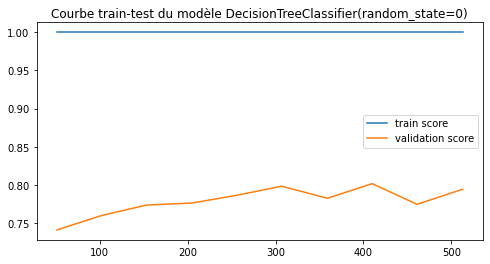

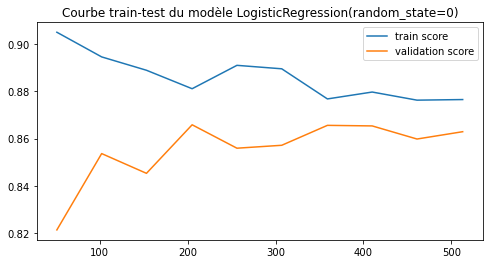

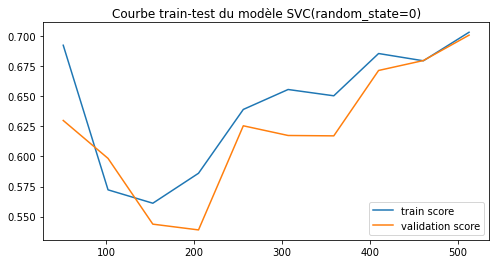

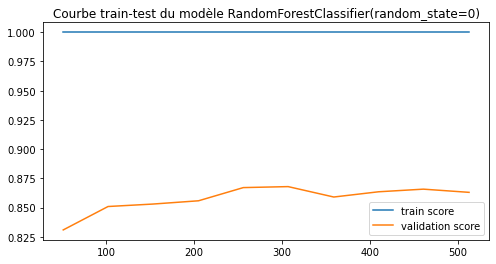

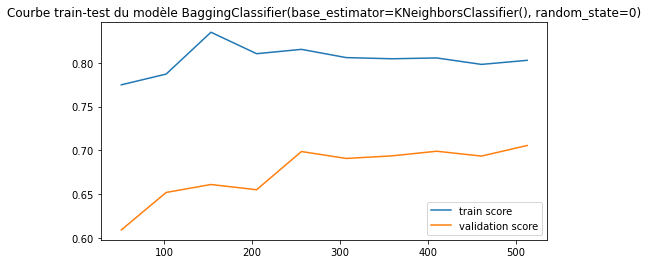

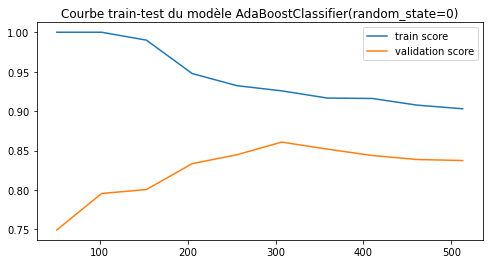

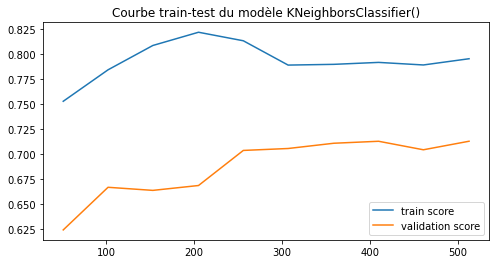

In [18]:
evaluation(modelList)

### 2ème approche: Encodage et normalisation (StandardScaler)

In [19]:
def model_evaluation_1(model_list):
    
    for item in model_list:
        model = make_pipeline(preprocessor_1, item)
        model.fit(X_train, y_train)
        
        print('=='*50)
        y_train_pred = model.predict(X_train)
        print(f"Évalution du modèle: {item}\n")
        print(classification_report(y_train, y_train_pred), "\n")
        
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                    cv=5, scoring = 'f1', 
                                                    train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(8,4))
        plt.title(f"Courbe train-test du modèle {item}")
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.legend()        

Évalution du modèle: DecisionTreeClassifier(random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       341

    accuracy                           1.00       642
   macro avg       1.00      1.00      1.00       642
weighted avg       1.00      1.00      1.00       642
 

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       109
           1       0.85      0.73      0.79       167

    accuracy                           0.76       276
   macro avg       0.76      0.77      0.76       276
weighted avg       0.78      0.76      0.76       276

Évalution du modèle: LogisticRegression(random_state=0)

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       301
           1       0.86      0.90      0.88       341

    accuracy                           0.87       642
   macro

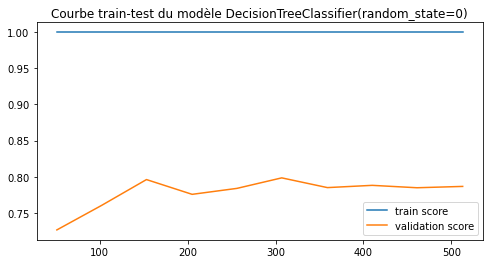

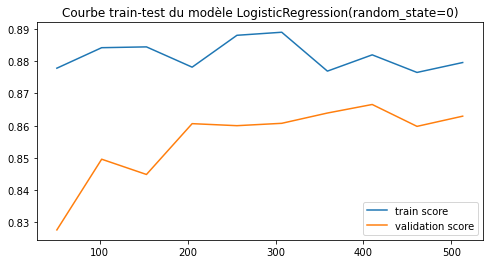

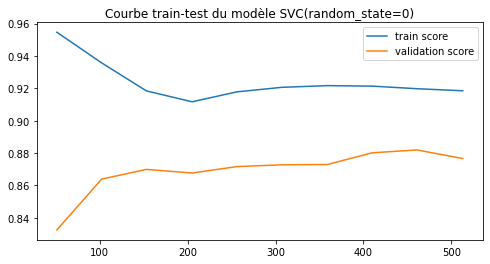

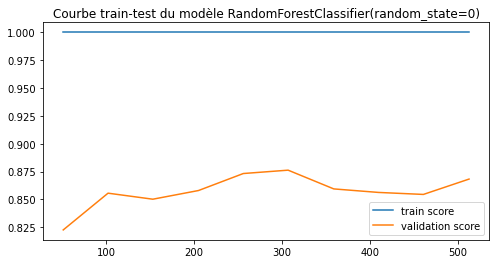

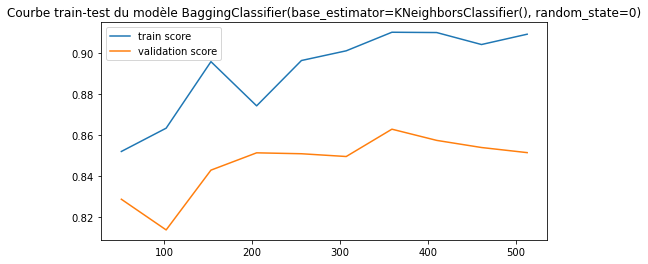

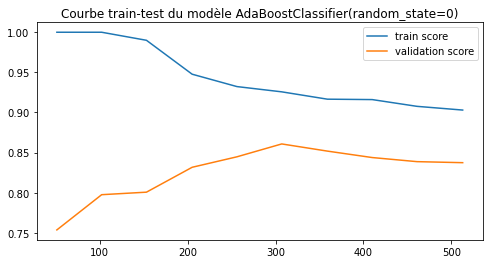

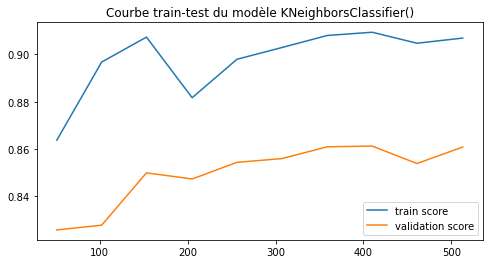

In [20]:
model_evaluation_1(modelList)

### 3ème approche: Encodage et normalisation (RobustScaler)

In [21]:
def model_evaluation_2(model_list):
    
    for item in model_list:
        model = make_pipeline(preprocessor_2, item)
        model.fit(X_train, y_train)
        
        print('=='*50)
        y_train_pred = model.predict(X_train)
        print(f"Évalution du modèle: {item}\n")
        print(classification_report(y_train, y_train_pred), "\n")
        
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                    cv=5, scoring = 'f1', 
                                                    train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(8,4))
        plt.title(f"Courbe train-test du modèle {item}")
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.legend()        

Évalution du modèle: DecisionTreeClassifier(random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       341

    accuracy                           1.00       642
   macro avg       1.00      1.00      1.00       642
weighted avg       1.00      1.00      1.00       642
 

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       109
           1       0.85      0.73      0.79       167

    accuracy                           0.76       276
   macro avg       0.76      0.77      0.76       276
weighted avg       0.78      0.76      0.76       276

Évalution du modèle: LogisticRegression(random_state=0)

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       301
           1       0.86      0.90      0.88       341

    accuracy                           0.87       642
   macro

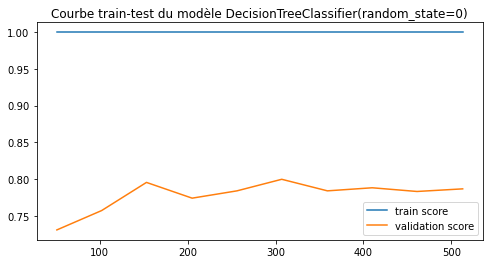

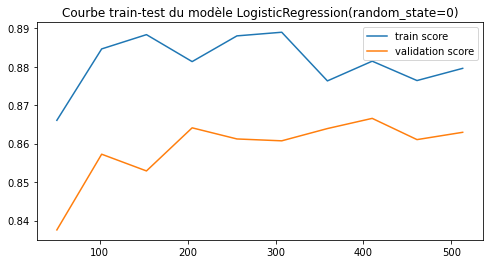

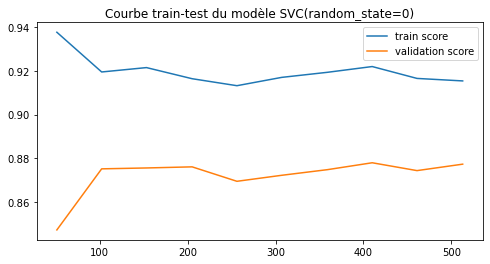

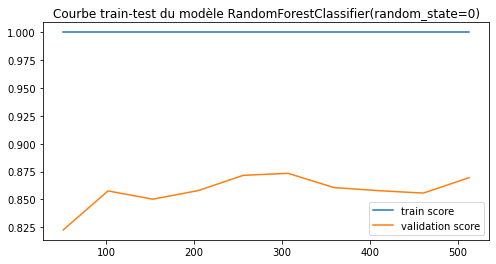

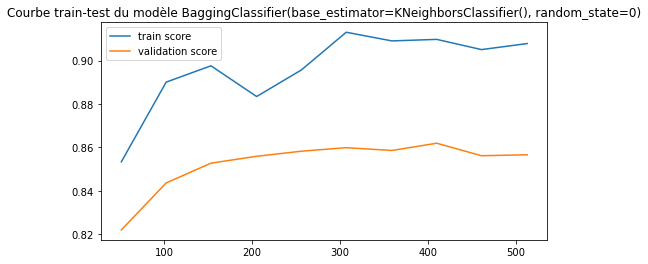

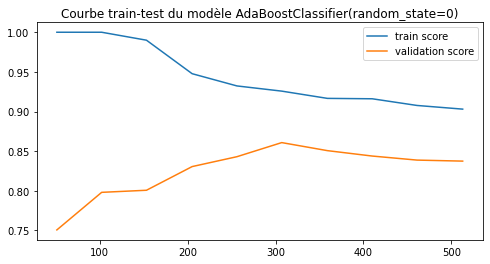

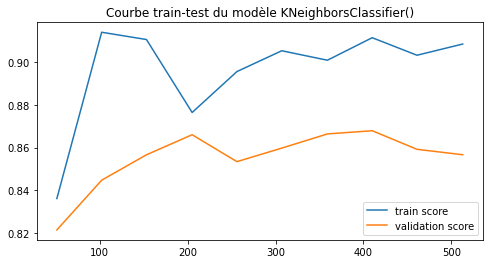

In [22]:
model_evaluation_2(modelList)

### COMMENTAIRES DU PREPROCESSING ET DE LA MODÉLISATION

**PREMIÈME APPROCHE: encodage seulement**

Dans cette deuxième approche, il s'agit d'entraîner les modèles avec les paramétrages standards des algorithmes utilisés et après avoir fait un preprocessing basique (StandardScaler et encodage). Aucune imputation n'a été réalisée. Après modélisation et évaluation des modèles, il en ressort que:

- les modèles basés sur les algorithmes de ***DecisionTreeClassifier***, ***RandomForestClassifier*** font encore du surapprentisage.
(*Les performances sur le jeu d'entraînement sont largement supérieures à celles sur les données test*)


- les modèles basés sur les algorithmes de ***Logistic Regression***, ***Support Vecteur Machine***(SVC), ***AdaBoostClassifier***, ***KNeighborsClassifier***, ***BaggingClassifier*** donnent plutôt des résultats très encourangeants au niveau de l'apprentissage mais pas suffisants pour statuer.

**DEUXIÈME APPROCHE: encodage et normalisation (StandardScaler)**

Dans cette deuxième approche, il s'agit d'entraîner les modèles avec les paramétrages standards des algorithmes utilisés et après avoir fait un preprocessing basique (StandardScaler et encodage). Aucune imputation n'a été réalisée. Après modélisation et évaluation des modèles, il en ressort que:

- les modèles basés sur les algorithmes de ***DecisionTreeClassifier***, ***RandomForestClassifier*** font encore du surapprentisage.
(*Les performances sur le jeu d'entraînement sont largement supérieures à celles sur les données test*)


- les modèles basés sur les algorithmes de ***Logistic Regression***, ***Support Vecteur Machine***(SVC), ***AdaBoostClassifier***, ***KNeighborsClassifier***, ***BaggingClassifier*** donnent plutôt des résultats très encourangeants au niveau de l'apprentissage mais pas suffisants pour statuer.

**TROISIÈME APPROCHE: encodage et normalisation (RobustScaler)**

Cette troisième approche est la même que la précédente. La seule différence est la méthode de normalisation des données, le RobustScaler, qui est moins sensible aux valeurs abérrantes:

- Les performances des mêmes algorithmes que précédement se sont légèrement améliorées

- les modèles basés sur les algorithmes de ***DecisionTreeClassifier***, ***RandomForestClassifier*** font toujours du surapprentisage.
(*Les performances sur le jeu d'entraînement sont largement supérieures à celles sur les données test*)


- les modèles basés sur les algorithmes de ***Logistic Regression***, ***Support Vecteur Machine***(SVC), ***AdaBoostClassifier***, ***KNeighborsClassifier***, ***BaggingClassifier*** donnent plutôt des résultats très encourangeants au niveau de l'apprentissage mais pas suffisants pour statuer.